<a href="https://colab.research.google.com/github/cralji/RFF-Nerve-UTP/blob/main/FCN_Nerve-UTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# Import Packages

In [ ]:
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression,  SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE, SelectKBest, chi2
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from xml.etree import cElementTree as ElementTree
from keras_preprocessing.image import ImageDataGenerator
from sklearn.externals.six import StringIO  
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from IPython.display import Image  
import matplotlib.pyplot as plt
from sklearn import metrics 
from joblib import dump, load
import requests, zipfile, io
from sklearn import svm
import numpy as np
from numpy import mean, std
import seaborn as sns
import cv2
import scipy.io
import pandas as pd
import pydotplus
import os
from glob import glob
from PIL import Image
from math import sqrt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
import skimage
from skimage import segmentation

try:
  !pip install scikit-image
except:
  None

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Functions 

In [ ]:
#%% functionfor extract the image's mask from xml extensión file. 
def fun2(pathxml,pathimg, img_path, label_path,img_path_nerve, label_path_nerve):
  tree = ElementTree.parse(pathxml)
  root = tree.getroot()
  xy=[]
  d={}
  i=0
  for element in root:
    if len(element)==0:
      d[str(element.tag)]=str(element.text)
    else: 
      d[str(element.tag)]={}
    for sub in element:
      if len(sub)==0:
        d[str(element.tag)][str(sub.tag)]=str(sub.text)
      else:
        d[str(element.tag)][str(sub.tag)]={}
      for sub2 in sub:
        if len(sub2)==0:
          d[str(element.tag)][str(sub.tag)][str(sub2.tag)]=str(sub2.text)
        else:
          if str(sub2.tag)=="pt":
            i+=1
            d[str(element.tag)][str(sub.tag)][str(sub2.tag)+str(i)]={"x":sub2[0].text,"y":sub2[1].text}
            xy.append((sub2[0].text,sub2[1].text))
  pts = np.asarray(xy,np.int32)
  img=plt.imread(pathimg)
  img_poly = plt.imread(pathimg)
  img_labels = np.zeros((img[:,:,0].shape),dtype=np.uint8)
  cv2.fillPoly(img_poly,[pts], (255,0,0));  
  indices=np.where(np.all(img_poly== (255,0,0),axis=-1)) 
  img_labels[indices[0],indices[1]] = 1#255#255#1
  
  cv2.imwrite(img_path, img)
  cv2.imwrite(label_path, img_labels)

  cv2.imwrite(img_path_nerve, img)
  cv2.imwrite(label_path_nerve, img_labels)

# Load Data

## Download Dataset

In [ ]:
FILEID = "1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ImagenesNervios.zip && rm -rf /tmp/cookies.txt

--2021-09-09 21:57:25--  https://docs.google.com/uc?export=download&confirm=eeFI&id=1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU
Resolving docs.google.com (docs.google.com)... 108.177.111.113, 108.177.111.139, 108.177.111.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.111.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-6k-docs.googleusercontent.com/docs/securesc/tq9i592gidfvtk4aubvune8687g23200/hag07kag7pum6cm643e6t2t9orblurp7/1631224575000/05137136237839183901/12499214810954079622Z/1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU?e=download [following]
--2021-09-09 21:57:25--  https://doc-14-6k-docs.googleusercontent.com/docs/securesc/tq9i592gidfvtk4aubvune8687g23200/hag07kag7pum6cm643e6t2t9orblurp7/1631224575000/05137136237839183901/12499214810954079622Z/1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU?e=download
Resolving doc-14-6k-docs.googleusercontent.com (doc-14-6k-docs.googleusercontent.com)... 74.125.70.132, 2607:f8b0:4001:c02::84
Connect

In [ ]:
!unzip ImagenesNervios

Archive:  ImagenesNervios.zip
   creating: ImagenesNervios_/
  inflating: ImagenesNervios_/ciatico_1.png  
  inflating: ImagenesNervios_/ciatico_10.png  
  inflating: ImagenesNervios_/ciatico_100.png  
  inflating: ImagenesNervios_/ciatico_100_mask.png  
  inflating: ImagenesNervios_/ciatico_100_rf.png  
  inflating: ImagenesNervios_/ciatico_100_rf_mask.png  
  inflating: ImagenesNervios_/ciatico_100_uf.png  
  inflating: ImagenesNervios_/ciatico_100_uf_mask.png  
  inflating: ImagenesNervios_/ciatico_101.png  
  inflating: ImagenesNervios_/ciatico_101_mask.png  
  inflating: ImagenesNervios_/ciatico_101_rf.png  
  inflating: ImagenesNervios_/ciatico_101_rf_mask.png  
  inflating: ImagenesNervios_/ciatico_101_uf.png  
  inflating: ImagenesNervios_/ciatico_101_uf_mask.png  
  inflating: ImagenesNervios_/ciatico_102.png  
  inflating: ImagenesNervios_/ciatico_102_mask.png  
  inflating: ImagenesNervios_/ciatico_102_rf.png  
  inflating: ImagenesNervios_/ciatico_102_rf_mask.png  
  inflat

### original

In [ ]:
# r = requests.get('https://github.com/HaroldMDiazVargas/NerveProject/blob/main/ImagenesNervios.zip?raw=true') 
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall()

In [ ]:
# !mkdir ImagenesNervios/data
# !mkdir ImagenesNervios/ciatico
# !mkdir ImagenesNervios/cubital
# !mkdir ImagenesNervios/mediano
# !mkdir ImagenesNervios/femoral

# nerve = {0:'ciatico',9:'cubital',14:'mediano',17:'femoral'}

# total_img = 0
# nerve_img = 0
# j = 0
# for i in range(22):
  
#   if i == 0 or i == 9 or i == 14 or i == 17:
#     nerve_img = 0
#     act_nerv = nerve[i]
#     j = j+1
#   # path = "P"+str(i+1)+"_"+act_nerv
#   path = "./ImagenesNervios/"+"P"+str(i+1)+"_"+act_nerv+"/"
#   xml_name = [pos_xml for pos_xml in os.listdir(path) if pos_xml.endswith('.xml')]
  
#   for xml_file in xml_name:
#     nerve_img = nerve_img + 1
#     total_img = total_img + 1
#     img_path = "./ImagenesNervios/data/"+act_nerv+'_'+str(total_img)+'.png'
#     label_path = "./ImagenesNervios/data/"+act_nerv+'_'+str(total_img)+'_mask.png'
#     img_path_nerve = "./ImagenesNervios/"+act_nerv+"/"+str(nerve_img)+'.png'
#     label_path_nerve = "./ImagenesNervios/"+act_nerv+"/"+str(nerve_img)+'_mask.png'
#     path_xml = path+xml_file
#     path_img = path+xml_file[0:-4]+".jpg"
#     fun2(path_xml,path_img, img_path, label_path,img_path_nerve, label_path_nerve)

In [ ]:
# !mkdir Images
# !mv ./ImagenesNervios/data/ ./Images/data

## Relocate images and mask

In [ ]:
# file_images = glob('./Images/data/*.png')
file_images = glob('./ImagenesNervios_/*.png')

In [ ]:
file_images.sort()
filepath_image = [] # sólo imagenes
filepath_mask = [] # mascaras
nerve_name = []
for filepath in [filepath_ for filepath_ in file_images if 'mask' not in filepath_]:
  mask = filepath[:-4]+'_mask.png'
  if mask in file_images:
    filepath_image.append(filepath)
    filepath_mask.append(mask)

    if 'ciatico' in filepath:
      nerve_name.append('ciatico')
    elif 'cubital' in filepath:
      nerve_name.append('cubital')
    elif 'femoral' in filepath:
      nerve_name.append('femoral')
    elif 'mediano' in filepath:
      nerve_name.append('mediano')

df = pd.DataFrame({'filepath':filepath_image,'nerve_name':nerve_name,'mask':filepath_mask})
t = df['nerve_name']
df.head()

,filepath,nerve_name,mask
0,./ImagenesNervios_/ciatico_1.png,ciatico,./ImagenesNervios_/ciatico_1_mask.png
1,./ImagenesNervios_/ciatico_10.png,ciatico,./ImagenesNervios_/ciatico_10_mask.png
2,./ImagenesNervios_/ciatico_100.png,ciatico,./ImagenesNervios_/ciatico_100_mask.png
3,./ImagenesNervios_/ciatico_100_rf.png,ciatico,./ImagenesNervios_/ciatico_100_rf_mask.png
4,./ImagenesNervios_/ciatico_100_uf.png,ciatico,./ImagenesNervios_/ciatico_100_uf_mask.png


### Split sets

In [ ]:
df_train_images,df_test_images,t_train,_ = train_test_split(df,t, test_size=0.2,stratify = t)
df_train_images,df_val_images,_,_ = train_test_split(df_train_images,t_train, test_size=0.2,stratify = t_train)

360 x 279


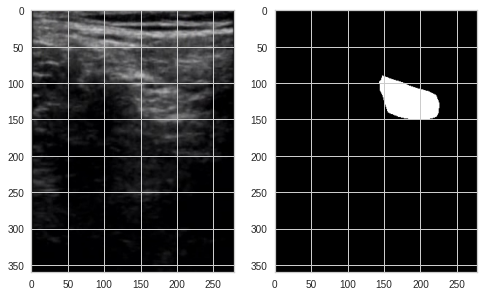

In [ ]:
img = cv2.imread(filepath_image[0])
mask = cv2.imread(filepath_mask[0])
height,width,_ = img.shape
print(height,'x',width)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask*255,cmap='gray')
plt.show()

### Data generator. 

In [ ]:
df_train_images

,filepath,nerve_name,mask
167,./ImagenesNervios_/ciatico_150.png,ciatico,./ImagenesNervios_/ciatico_150_mask.png
493,./ImagenesNervios_/ciatico_248_uf.png,ciatico,./ImagenesNervios_/ciatico_248_uf_mask.png
398,./ImagenesNervios_/ciatico_21_rf.png,ciatico,./ImagenesNervios_/ciatico_21_rf_mask.png
279,./ImagenesNervios_/ciatico_184_rf.png,ciatico,./ImagenesNervios_/ciatico_184_rf_mask.png
265,./ImagenesNervios_/ciatico_18.png,ciatico,./ImagenesNervios_/ciatico_18_mask.png
...,...,...,...
520,./ImagenesNervios_/ciatico_256_uf.png,ciatico,./ImagenesNervios_/ciatico_256_uf_mask.png
768,./ImagenesNervios_/ciatico_71_uf.png,ciatico,./ImagenesNervios_/ciatico_71_uf_mask.png
722,./ImagenesNervios_/ciatico_58_rf.png,ciatico,./ImagenesNervios_/ciatico_58_rf_mask.png
1702,./ImagenesNervios_/femoral_609_rf.png,femoral,./ImagenesNervios_/femoral_609_rf_mask.png


In [ ]:
def preprocessing_mask(mask):
  mask[mask > 0.5] = 255
  mask[mask <= 0.5] = 0
  return mask

In [ ]:
seed = 1993
batch_size = 32
height,width = 128,128
image_datagen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255)

image_datagen_mask = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255,
                                   preprocessing_function = preprocessing_mask)

generator_train_img = image_datagen.flow_from_dataframe(df_train_images,
                                                        x_col = 'filepath',
                                                        batch_size = batch_size,
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        seed = seed)

generator_train_mask = image_datagen_mask.flow_from_dataframe(df_train_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale", 
                                                         batch_size = batch_size,
                                                         target_size = (height,width),
                                                         seed = seed)

train_gen = zip(generator_train_img,generator_train_mask)


generator_val_img = image_datagen.flow_from_dataframe(df_val_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_val_mask = image_datagen_mask.flow_from_dataframe(df_val_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

val_gen = zip(generator_val_img,generator_val_mask)


generator_test_img = image_datagen.flow_from_dataframe(df_test_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_test_mask = image_datagen_mask.flow_from_dataframe(df_test_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

test_gen = zip(generator_test_img,generator_test_mask)


Found 1188 validated image filenames.
Found 1188 validated image filenames.
Found 297 validated image filenames.
Found 297 validated image filenames.
Found 372 validated image filenames.
Found 372 validated image filenames.


[0. 1.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: No contour levels were found within the data range.
  """


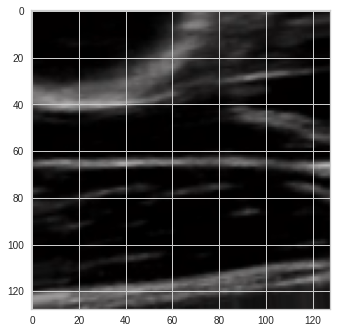

In [ ]:
i,j = next(train_gen)
print(np.unique(j))
plt.imshow(i[0,:,:,:])
edges_est = segmentation.clear_border(j[0,:,:,0])
plt.contour(edges_est,[0.5])
plt.show()

# Build Model 

## need functions

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def renny_entropy(ytrue,ypred):
    Ke = tf.matmul(ypred,ypred,transpose_b=True)
    Ke = Ke/tf.linalg.trace(Ke)
    #entropy_renny  = (1/(1-2))*tf.math.log((1/tf.constant(32*32,dtype=ypred.dtype))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True)))
    entropy_renny = tf.constant(1/(1-2))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True))
    return entropy_renny


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))#123456789
# path = "./ImagenesNervios/data/"data_image = [] data_mask = glob(path + '*_mask*') for i in data_mask:  data_image.append(i.replace('_mask', '')) print("Cantidad total de datos:",len(data_image))

    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.layers.experimental import RandomFourierFeatures
GAUSSIAN_NOISE = 0.1
ACTIVATION = 'relu'
def fcn(image_size,ch_in=3, ch_out=1):
    
    # inputs = Input(shape=(*image_size, ch_in), name='input')

    # # Building a pre-trained VGG-16 feature extractor (i.e., without the final FC layers)
    # vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)
    # # Recovering the feature maps generated by each of the 3 final blocks:
    # f3 = vgg16.get_layer('block3_pool').output  
    # f4 = vgg16.get_layer('block4_pool').output  
    # f5 = vgg16.get_layer('block5_pool').output  

    # Replacing VGG dense layers by convolutions:

    inputs = Input((*image_size, ch_in), name = 'RGB_Input')
    gn_inputs = GaussianNoise(GAUSSIAN_NOISE)(inputs)
    bn_inputs = BatchNormalization()(gn_inputs)
    f1 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (bn_inputs)

    f1 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f1)
    f1 = BatchNormalization()(f1)
    f1 = MaxPooling2D((2, 2)) (f1)

    f2 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f1)#(inputs)
    f2 = Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (f2)
    f2 = BatchNormalization()(f2)
    f2 = MaxPooling2D((2, 2)) (f2)

    f3 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (f2)#(inputs)
    f3 = Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (f3)
    f3 = BatchNormalization()(f3)
    f3 = MaxPooling2D((2, 2)) (f3)

    f4 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (f3)
    f4 = Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (f4)
    f4 = BatchNormalization()(f4)
    f4 = MaxPooling2D((2, 2)) (f4)

    f5 = Conv2D(256, (3, 3), activation=ACTIVATION, padding='same') (f4)
    f5 = Conv2D(256, (3, 3), activation=ACTIVATION, padding='same') (f5)
    f5 = BatchNormalization()(f5)
    f5 = MaxPooling2D((2, 2)) (f5)


    #%% Modified by CAJ
    # flatten = Flatten()(f5)
    # rff = RandomFourierFeatures(output_dim=int(height/32)*int(width/32)*phi_units,trainable=True,name = 'Phi')(flatten)
    # resha = Reshape((int(height/32),int(width/32),-1))(rff)
    # f6 = Conv2D(ch_out, (1, 1), activation=ACTIVATION, padding='same') (resha)
    #%% End modify
    
    # f5_conv1 = Conv2D(filters=4086, kernel_size=7, padding='same',
    #                   activation='relu')(resha)#(f5)
    # f5_drop1 = Dropout(0.5)(f5_conv1)
    # f5_conv2 = Conv2D(filters=4086, kernel_size=1, padding='same',
    #                   activation='relu')(f5_drop1)
    # f5_drop2 = Dropout(0.5)(f5_conv2)
    # f5_conv3 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
    #                   activation=None)(f5_drop2)
    

    # Using a transposed conv (w/ s=2) to upscale `f5` into a 14 x 14 map
    # so it can be merged with features from `f4_conv1` obtained from `f4`:
    f5_conv3_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(f5) #(resha)
    f4_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f4)

    # Merging the 2 feature maps (addition):
    merge1 = add([f4_conv1,f5_conv3_x2])

    # We repeat the operation to merge `merge1` and `f3` into a 28 x 28 map:
    merge1_x2 = Conv2DTranspose(filters=ch_out, kernel_size=4, strides=2,
                                use_bias=False, padding='same', activation='relu')(merge1)
    f3_conv1 = Conv2D(filters=ch_out, kernel_size=1, padding='same',
                      activation=None)(f3)
    merge2 = add([f3_conv1, merge1_x2])

    # Finally, we use another transposed conv to decode and up-scale the feature map
    # to the original shape, i.e., using a stride 8 to go from 28 x 28 to 224 x 224 here:
    outputs = Conv2DTranspose(filters=1, kernel_size=16, strides=8,
                              padding='same', activation='sigmoid',name='output')(merge2)
    
    fcn_model = Model(inputs, outputs)
    return fcn_model

seg_model = fcn((128,128),1)

seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 128, 128, 1)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 1)  4           gaussian_noise[0][0]             
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         batch_normalization[0][0]        
______________________________________________________________________________________________

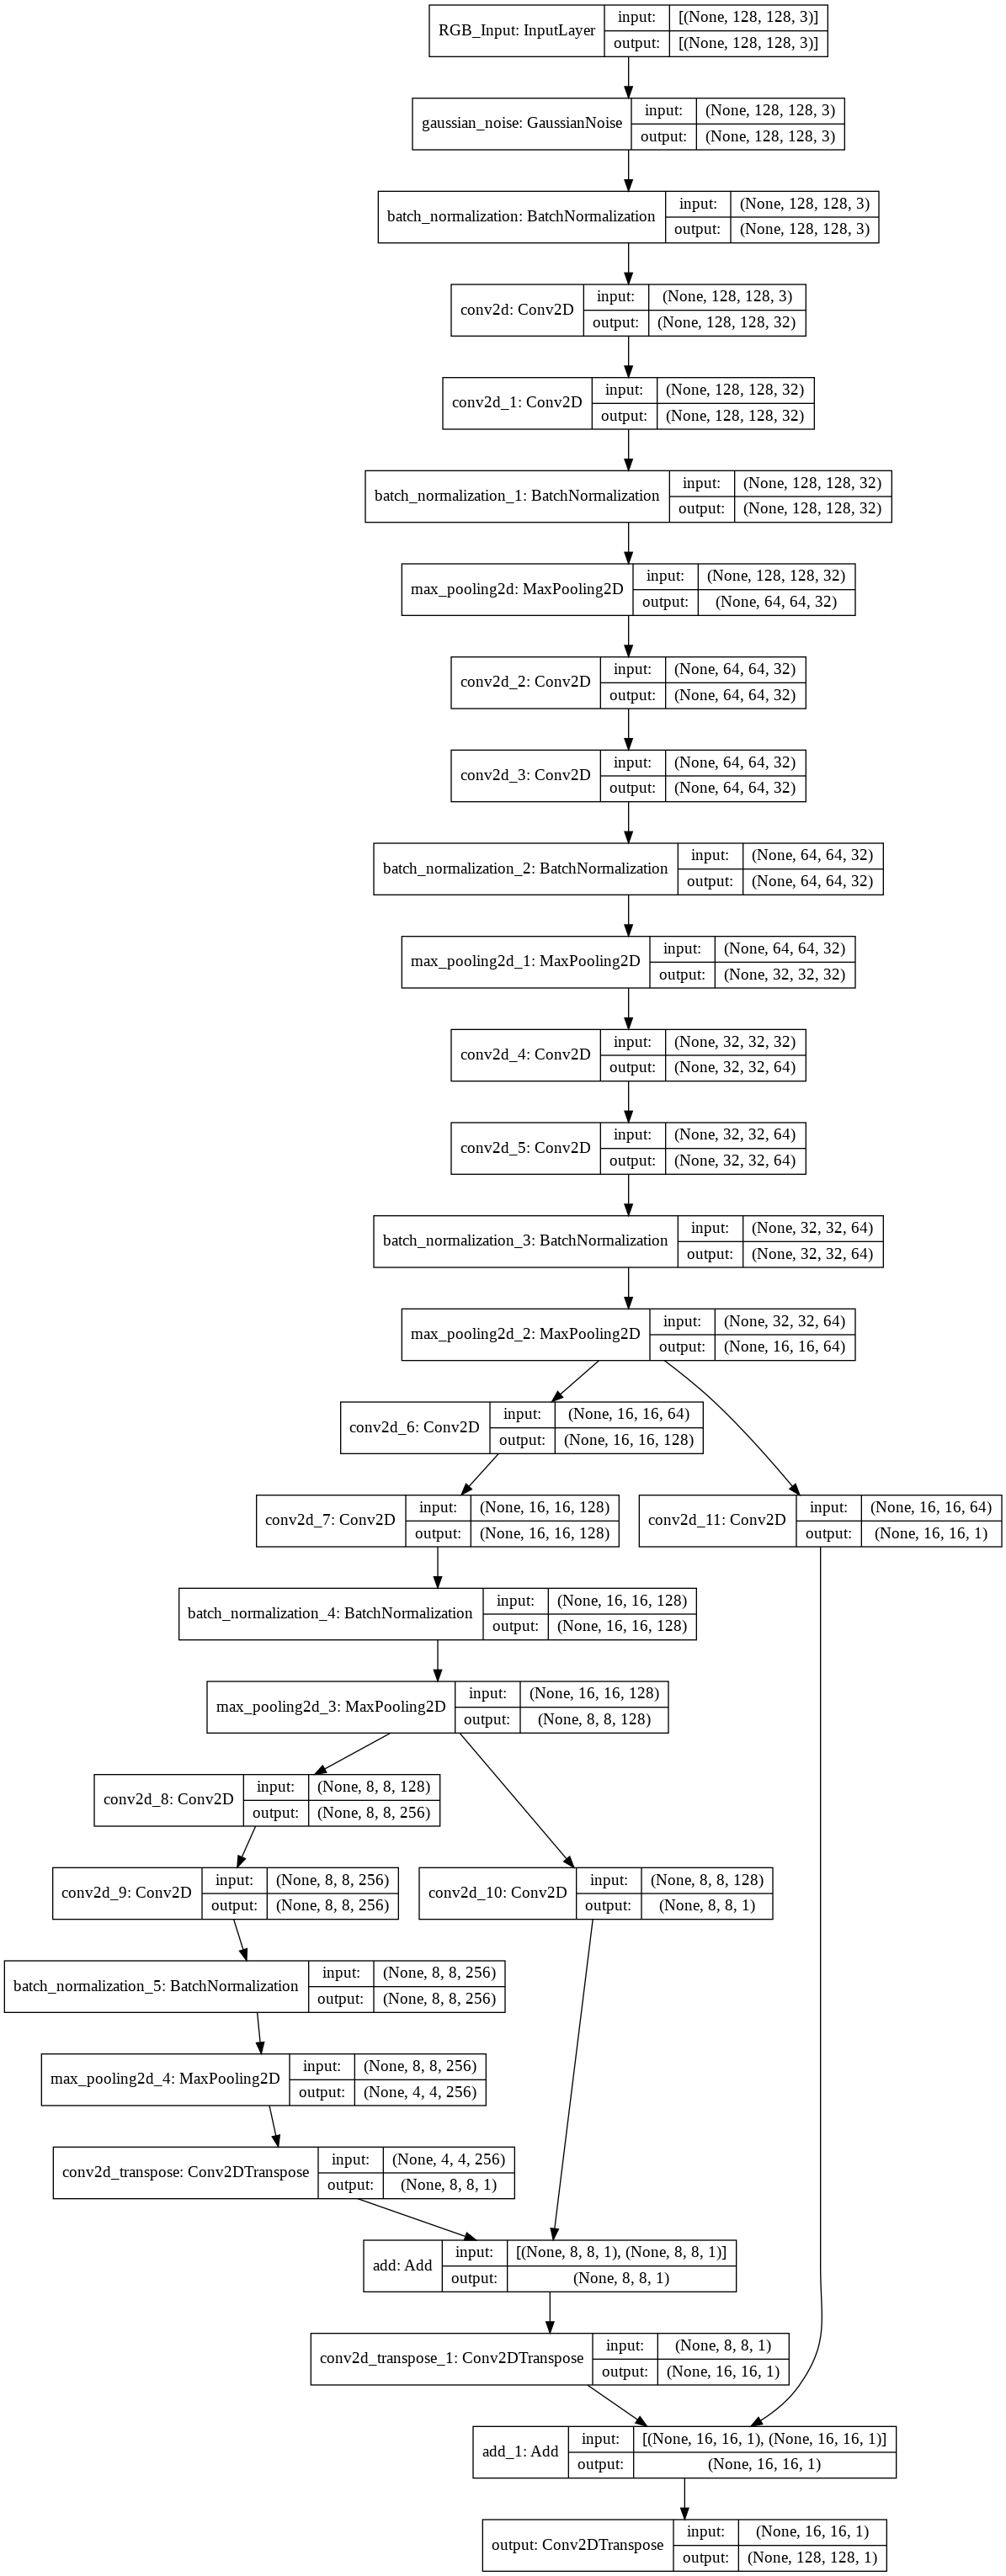

In [ ]:
tf.keras.utils.plot_model(seg_model,show_shapes=True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
37/37 [==============================] - 33s 372ms/step - loss: -0.1513 - iou: 0.0826 - dice_coef: 0.1520 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.5958 - val_loss: -0.1064 - val_iou: 0.0562 - val_dice_coef: 0.1064 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8058


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 2/200
 1/37 [..............................] - ETA: 1s - loss: -0.1965 - iou: 0.1090 - dice_coef: 0.1965 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.7178

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 356ms/step - loss: -0.3686 - iou: 0.2304 - dice_coef: 0.3686 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8672 - val_loss: -0.0073 - val_iou: 0.0037 - val_dice_coef: 0.0073 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9355


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 3/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.5700 - iou: 0.3995 - dice_coef: 0.5700 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9456 - val_loss: -0.0015 - val_iou: 7.4415e-04 - val_dice_coef: 0.0015 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9372


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 4/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.6294 - iou: 0.4629 - dice_coef: 0.6309 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9535 - val_loss: -0.0154 - val_iou: 0.0078 - val_dice_coef: 0.0154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9379


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 5/200
 1/37 [..............................] - ETA: 1s - loss: -0.4124 - iou: 0.2598 - dice_coef: 0.4124 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9306

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 357ms/step - loss: -0.6623 - iou: 0.5009 - dice_coef: 0.6652 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9585 - val_loss: -0.1156 - val_iou: 0.0621 - val_dice_coef: 0.1156 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9392


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 6/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.6785 - iou: 0.5139 - dice_coef: 0.6772 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9608 - val_loss: -3.3725e-04 - val_iou: 1.8392e-04 - val_dice_coef: 3.3725e-04 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9375


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 7/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 358ms/step - loss: -0.6974 - iou: 0.5361 - dice_coef: 0.6960 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9625 - val_loss: -0.0790 - val_iou: 0.0414 - val_dice_coef: 0.0790 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9396


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/200
37/37 [==============================] - 13s 359ms/step - loss: -0.7014 - iou: 0.5464 - dice_coef: 0.7031 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9634 - val_loss: -0.2213 - val_iou: 0.1250 - val_dice_coef: 0.2213 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9398


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 9/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 359ms/step - loss: -0.7094 - iou: 0.5520 - dice_coef: 0.7095 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9634 - val_loss: -0.0431 - val_iou: 0.0223 - val_dice_coef: 0.0431 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9382


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 10/200
 1/37 [..............................] - ETA: 1s - loss: -0.3368 - iou: 0.2025 - dice_coef: 0.3368 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9239

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 359ms/step - loss: -0.7167 - iou: 0.5612 - dice_coef: 0.7158 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9653 - val_loss: -0.4598 - val_iou: 0.3030 - val_dice_coef: 0.4598 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9499


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 11/200
 1/37 [..............................] - ETA: 1s - loss: -0.3725 - iou: 0.2289 - dice_coef: 0.3725 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9278

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 357ms/step - loss: -0.7314 - iou: 0.5769 - dice_coef: 0.7286 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9679 - val_loss: -0.4923 - val_iou: 0.3305 - val_dice_coef: 0.4923 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9542


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 12/200
 1/37 [..............................] - ETA: 1s - loss: -0.3165 - iou: 0.1880 - dice_coef: 0.3165 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9135

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.7413 - iou: 0.5923 - dice_coef: 0.7404 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9680 - val_loss: -0.3663 - val_iou: 0.2277 - val_dice_coef: 0.3663 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9466


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 13/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.7540 - iou: 0.6094 - dice_coef: 0.7542 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9696 - val_loss: -0.5346 - val_iou: 0.3689 - val_dice_coef: 0.5346 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9546


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 14/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.7560 - iou: 0.6099 - dice_coef: 0.7558 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9704 - val_loss: -0.5669 - val_iou: 0.3997 - val_dice_coef: 0.5669 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9549


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 15/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 16s 431ms/step - loss: -0.7622 - iou: 0.6222 - dice_coef: 0.7631 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9710 - val_loss: -0.5289 - val_iou: 0.3628 - val_dice_coef: 0.5289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9529


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 16/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.7610 - iou: 0.6226 - dice_coef: 0.7619 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9708 - val_loss: -0.6195 - val_iou: 0.4541 - val_dice_coef: 0.6195 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9557


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 17/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 356ms/step - loss: -0.7721 - iou: 0.6321 - dice_coef: 0.7709 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9717 - val_loss: -0.5866 - val_iou: 0.4233 - val_dice_coef: 0.5866 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9585


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 18/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.7801 - iou: 0.6426 - dice_coef: 0.7801 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9726 - val_loss: -0.6154 - val_iou: 0.4529 - val_dice_coef: 0.6154 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9576


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 19/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 358ms/step - loss: -0.7787 - iou: 0.6419 - dice_coef: 0.7793 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9731 - val_loss: -0.5574 - val_iou: 0.3914 - val_dice_coef: 0.5574 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9570


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 20/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.7876 - iou: 0.6552 - dice_coef: 0.7882 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9736 - val_loss: -0.5275 - val_iou: 0.3683 - val_dice_coef: 0.5275 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9560


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 21/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.7903 - iou: 0.6561 - dice_coef: 0.7902 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9741 - val_loss: -0.5899 - val_iou: 0.4251 - val_dice_coef: 0.5899 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9601


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/200
37/37 [==============================] - 13s 360ms/step - loss: -0.7957 - iou: 0.6616 - dice_coef: 0.7933 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9749 - val_loss: -0.6305 - val_iou: 0.4749 - val_dice_coef: 0.6305 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9585


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 23/200
 1/37 [..............................] - ETA: 0s - loss: -0.3981 - iou: 0.2485 - dice_coef: 0.3981 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9221

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 359ms/step - loss: -0.7915 - iou: 0.6602 - dice_coef: 0.7923 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9744 - val_loss: -0.6408 - val_iou: 0.4816 - val_dice_coef: 0.6408 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9613


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 24/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 355ms/step - loss: -0.8026 - iou: 0.6723 - dice_coef: 0.8009 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9757 - val_loss: -0.6712 - val_iou: 0.5080 - val_dice_coef: 0.6712 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9644


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 25/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8070 - iou: 0.6823 - dice_coef: 0.8084 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9761 - val_loss: -0.5933 - val_iou: 0.4252 - val_dice_coef: 0.5933 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9604


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 26/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 357ms/step - loss: -0.8116 - iou: 0.6882 - dice_coef: 0.8132 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9764 - val_loss: -0.6141 - val_iou: 0.4578 - val_dice_coef: 0.6141 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9606


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 27/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8118 - iou: 0.6849 - dice_coef: 0.8107 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9771 - val_loss: -0.6041 - val_iou: 0.4404 - val_dice_coef: 0.6041 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9587


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 28/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8078 - iou: 0.6822 - dice_coef: 0.8078 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9761 - val_loss: -0.5356 - val_iou: 0.3679 - val_dice_coef: 0.5356 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9572


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 29/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 15s 429ms/step - loss: -0.8118 - iou: 0.6889 - dice_coef: 0.8125 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9771 - val_loss: -0.4928 - val_iou: 0.3290 - val_dice_coef: 0.4928 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9555


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 30/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8159 - iou: 0.6936 - dice_coef: 0.8167 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9769 - val_loss: -0.6103 - val_iou: 0.4444 - val_dice_coef: 0.6103 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9616


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 31/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 358ms/step - loss: -0.8175 - iou: 0.6948 - dice_coef: 0.8173 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9775 - val_loss: -0.7024 - val_iou: 0.5461 - val_dice_coef: 0.7024 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9667


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 32/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 358ms/step - loss: -0.8125 - iou: 0.6937 - dice_coef: 0.8140 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9777 - val_loss: -0.6555 - val_iou: 0.5012 - val_dice_coef: 0.6555 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9635


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 33/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 15s 424ms/step - loss: -0.8201 - iou: 0.6999 - dice_coef: 0.8195 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9775 - val_loss: -0.6706 - val_iou: 0.5145 - val_dice_coef: 0.6706 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9648


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/200
37/37 [==============================] - 13s 366ms/step - loss: -0.8244 - iou: 0.7055 - dice_coef: 0.8252 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9782 - val_loss: -0.7441 - val_iou: 0.5976 - val_dice_coef: 0.7441 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9703


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 35/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8262 - iou: 0.7088 - dice_coef: 0.8269 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9785 - val_loss: -0.7069 - val_iou: 0.5600 - val_dice_coef: 0.7069 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9661


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 36/200
 1/37 [..............................] - ETA: 1s - loss: -0.3843 - iou: 0.2379 - dice_coef: 0.3843 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9191

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8245 - iou: 0.7060 - dice_coef: 0.8241 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9781 - val_loss: -0.7126 - val_iou: 0.5660 - val_dice_coef: 0.7126 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9652


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 37/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 359ms/step - loss: -0.8244 - iou: 0.7037 - dice_coef: 0.8223 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9784 - val_loss: -0.6862 - val_iou: 0.5384 - val_dice_coef: 0.6862 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9648


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 38/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8156 - iou: 0.6967 - dice_coef: 0.8172 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9773 - val_loss: -0.6211 - val_iou: 0.4608 - val_dice_coef: 0.6211 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9620


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 39/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 358ms/step - loss: -0.8288 - iou: 0.7120 - dice_coef: 0.8286 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.7093 - val_iou: 0.5546 - val_dice_coef: 0.7093 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9674


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 40/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8303 - iou: 0.7140 - dice_coef: 0.8303 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9789 - val_loss: -0.7294 - val_iou: 0.5745 - val_dice_coef: 0.7294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9711


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 41/200
 1/37 [..............................] - ETA: 0s - loss: -0.8483 - iou: 0.7366 - dice_coef: 0.8483 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9836

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8387 - iou: 0.7228 - dice_coef: 0.8389 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9802 - val_loss: -0.7116 - val_iou: 0.5608 - val_dice_coef: 0.7116 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9686


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 42/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.8294 - iou: 0.7146 - dice_coef: 0.8302 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9783 - val_loss: -0.7253 - val_iou: 0.5751 - val_dice_coef: 0.7253 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9703


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 43/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8347 - iou: 0.7155 - dice_coef: 0.8315 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9798 - val_loss: -0.7665 - val_iou: 0.6303 - val_dice_coef: 0.7665 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9732


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 44/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.8393 - iou: 0.7250 - dice_coef: 0.8387 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9801 - val_loss: -0.7193 - val_iou: 0.5836 - val_dice_coef: 0.7193 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9685


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 45/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 356ms/step - loss: -0.8392 - iou: 0.7297 - dice_coef: 0.8399 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9801 - val_loss: -0.7668 - val_iou: 0.6290 - val_dice_coef: 0.7668 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9727


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 46/200
 1/37 [..............................] - ETA: 1s - loss: -0.4257 - iou: 0.2704 - dice_coef: 0.4257 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9276

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 361ms/step - loss: -0.8337 - iou: 0.7184 - dice_coef: 0.8329 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9795 - val_loss: -0.7764 - val_iou: 0.6407 - val_dice_coef: 0.7764 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9733


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 47/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8419 - iou: 0.7303 - dice_coef: 0.8414 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9800 - val_loss: -0.7648 - val_iou: 0.6312 - val_dice_coef: 0.7648 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9729


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 48/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8398 - iou: 0.7298 - dice_coef: 0.8411 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.7606 - val_iou: 0.6300 - val_dice_coef: 0.7606 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9720


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 49/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8438 - iou: 0.7368 - dice_coef: 0.8448 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9804 - val_loss: -0.7353 - val_iou: 0.5934 - val_dice_coef: 0.7353 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9707


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 50/200
37/37 [==============================] - 13s 359ms/step - loss: -0.8457 - iou: 0.7399 - dice_coef: 0.8467 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.7390 - val_iou: 0.5981 - val_dice_coef: 0.7390 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9698


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 51/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8430 - iou: 0.7336 - dice_coef: 0.8430 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9808 - val_loss: -0.7289 - val_iou: 0.5817 - val_dice_coef: 0.7289 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9708


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 52/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 358ms/step - loss: -0.8548 - iou: 0.7490 - dice_coef: 0.8556 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.7619 - val_iou: 0.6336 - val_dice_coef: 0.7619 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9707


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 53/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 359ms/step - loss: -0.8469 - iou: 0.7412 - dice_coef: 0.8475 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9811 - val_loss: -0.7726 - val_iou: 0.6506 - val_dice_coef: 0.7726 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9722


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 54/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8502 - iou: 0.7420 - dice_coef: 0.8495 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.7613 - val_iou: 0.6310 - val_dice_coef: 0.7613 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9717


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 55/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.8528 - iou: 0.7483 - dice_coef: 0.8536 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9821 - val_loss: -0.7600 - val_iou: 0.6266 - val_dice_coef: 0.7600 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9729


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 56/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8432 - iou: 0.7321 - dice_coef: 0.8426 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9805 - val_loss: -0.7673 - val_iou: 0.6343 - val_dice_coef: 0.7673 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9717


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 57/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8477 - iou: 0.7428 - dice_coef: 0.8486 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9810 - val_loss: -0.7813 - val_iou: 0.6500 - val_dice_coef: 0.7813 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9734


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 58/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8478 - iou: 0.7404 - dice_coef: 0.8470 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9812 - val_loss: -0.7632 - val_iou: 0.6428 - val_dice_coef: 0.7632 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9719


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 59/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8528 - iou: 0.7475 - dice_coef: 0.8529 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9816 - val_loss: -0.7839 - val_iou: 0.6612 - val_dice_coef: 0.7839 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9742


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 60/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 16s 436ms/step - loss: -0.8519 - iou: 0.7494 - dice_coef: 0.8519 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.7761 - val_iou: 0.6555 - val_dice_coef: 0.7761 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 61/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 16s 432ms/step - loss: -0.8554 - iou: 0.7536 - dice_coef: 0.8566 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9819 - val_loss: -0.7901 - val_iou: 0.6747 - val_dice_coef: 0.7901 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9739


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 62/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8601 - iou: 0.7596 - dice_coef: 0.8608 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9827 - val_loss: -0.7898 - val_iou: 0.6711 - val_dice_coef: 0.7898 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9740


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 63/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 373ms/step - loss: -0.8540 - iou: 0.7528 - dice_coef: 0.8539 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9820 - val_loss: -0.7974 - val_iou: 0.6751 - val_dice_coef: 0.7974 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 64/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8581 - iou: 0.7564 - dice_coef: 0.8586 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.8030 - val_iou: 0.6826 - val_dice_coef: 0.8030 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9759


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 65/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8615 - iou: 0.7598 - dice_coef: 0.8608 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9828 - val_loss: -0.7872 - val_iou: 0.6711 - val_dice_coef: 0.7872 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9727


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 66/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8589 - iou: 0.7611 - dice_coef: 0.8595 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.7973 - val_iou: 0.6701 - val_dice_coef: 0.7973 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9752


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 67/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8609 - iou: 0.7626 - dice_coef: 0.8612 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9824 - val_loss: -0.8141 - val_iou: 0.6929 - val_dice_coef: 0.8141 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 68/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.8622 - iou: 0.7635 - dice_coef: 0.8624 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.7957 - val_iou: 0.6705 - val_dice_coef: 0.7957 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 69/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 372ms/step - loss: -0.8630 - iou: 0.7642 - dice_coef: 0.8631 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.7782 - val_iou: 0.6506 - val_dice_coef: 0.7782 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9748


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 70/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8613 - iou: 0.7620 - dice_coef: 0.8617 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.7891 - val_iou: 0.6637 - val_dice_coef: 0.7891 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9756


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 71/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8651 - iou: 0.7656 - dice_coef: 0.8631 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9829 - val_loss: -0.8070 - val_iou: 0.6831 - val_dice_coef: 0.8070 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 72/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8634 - iou: 0.7654 - dice_coef: 0.8638 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9830 - val_loss: -0.7765 - val_iou: 0.6516 - val_dice_coef: 0.7765 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 73/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.8676 - iou: 0.7719 - dice_coef: 0.8686 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.7951 - val_iou: 0.6775 - val_dice_coef: 0.7951 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9729


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 74/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8701 - iou: 0.7701 - dice_coef: 0.8681 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.7716 - val_iou: 0.6357 - val_dice_coef: 0.7716 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9731


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 75/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8509 - iou: 0.7468 - dice_coef: 0.8511 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9815 - val_loss: -0.8022 - val_iou: 0.6856 - val_dice_coef: 0.8022 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 76/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 372ms/step - loss: -0.8645 - iou: 0.7687 - dice_coef: 0.8655 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9831 - val_loss: -0.8170 - val_iou: 0.6991 - val_dice_coef: 0.8170 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9777


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 77/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 371ms/step - loss: -0.8649 - iou: 0.7702 - dice_coef: 0.8658 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9833 - val_loss: -0.8030 - val_iou: 0.6808 - val_dice_coef: 0.8030 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 78/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 372ms/step - loss: -0.8670 - iou: 0.7722 - dice_coef: 0.8670 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.8533 - val_iou: 0.7444 - val_dice_coef: 0.8533 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9823


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 79/200
 1/37 [..............................] - ETA: 0s - loss: -0.8461 - iou: 0.7333 - dice_coef: 0.8461 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 373ms/step - loss: -0.8752 - iou: 0.7772 - dice_coef: 0.8745 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.7892 - val_iou: 0.6630 - val_dice_coef: 0.7892 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9762


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 80/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8598 - iou: 0.7611 - dice_coef: 0.8590 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9825 - val_loss: -0.8207 - val_iou: 0.7031 - val_dice_coef: 0.8207 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9783


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 81/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 16s 434ms/step - loss: -0.8671 - iou: 0.7702 - dice_coef: 0.8667 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9834 - val_loss: -0.8157 - val_iou: 0.7013 - val_dice_coef: 0.8157 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 82/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8663 - iou: 0.7737 - dice_coef: 0.8676 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9832 - val_loss: -0.8120 - val_iou: 0.6930 - val_dice_coef: 0.8120 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 83/200
37/37 [==============================] - 16s 437ms/step - loss: -0.8687 - iou: 0.7732 - dice_coef: 0.8692 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9839 - val_loss: -0.7945 - val_iou: 0.6718 - val_dice_coef: 0.7945 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 84/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8707 - iou: 0.7779 - dice_coef: 0.8714 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.7978 - val_iou: 0.6806 - val_dice_coef: 0.7978 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 85/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8768 - iou: 0.7865 - dice_coef: 0.8776 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.8080 - val_iou: 0.6925 - val_dice_coef: 0.8080 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9770


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 86/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8743 - iou: 0.7819 - dice_coef: 0.8746 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.7821 - val_iou: 0.6693 - val_dice_coef: 0.7821 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9747


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 87/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8747 - iou: 0.7847 - dice_coef: 0.8757 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.8087 - val_iou: 0.6934 - val_dice_coef: 0.8087 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 88/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8683 - iou: 0.7739 - dice_coef: 0.8674 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.8103 - val_iou: 0.6960 - val_dice_coef: 0.8103 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 89/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8766 - iou: 0.7847 - dice_coef: 0.8766 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9848 - val_loss: -0.7865 - val_iou: 0.6767 - val_dice_coef: 0.7865 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9749


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 90/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 372ms/step - loss: -0.8752 - iou: 0.7834 - dice_coef: 0.8753 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9845 - val_loss: -0.8235 - val_iou: 0.7093 - val_dice_coef: 0.8235 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 91/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8659 - iou: 0.7728 - dice_coef: 0.8658 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9837 - val_loss: -0.7908 - val_iou: 0.6759 - val_dice_coef: 0.7908 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9750


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 92/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8729 - iou: 0.7804 - dice_coef: 0.8725 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.8105 - val_iou: 0.6992 - val_dice_coef: 0.8105 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9758


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 93/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.8756 - iou: 0.7852 - dice_coef: 0.8760 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9842 - val_loss: -0.8241 - val_iou: 0.7136 - val_dice_coef: 0.8241 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 94/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8753 - iou: 0.7865 - dice_coef: 0.8761 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9844 - val_loss: -0.8288 - val_iou: 0.7212 - val_dice_coef: 0.8288 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 95/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8809 - iou: 0.7915 - dice_coef: 0.8813 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8089 - val_iou: 0.7038 - val_dice_coef: 0.8089 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 96/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8774 - iou: 0.7863 - dice_coef: 0.8771 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.8077 - val_iou: 0.6975 - val_dice_coef: 0.8077 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9757


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 97/200
37/37 [==============================] - 13s 367ms/step - loss: -0.8800 - iou: 0.7899 - dice_coef: 0.8798 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8224 - val_iou: 0.7163 - val_dice_coef: 0.8224 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 98/200
37/37 [==============================] - 13s 371ms/step - loss: -0.8744 - iou: 0.7826 - dice_coef: 0.8732 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.8357 - val_iou: 0.7248 - val_dice_coef: 0.8357 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 99/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8791 - iou: 0.7892 - dice_coef: 0.8791 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9852 - val_loss: -0.8283 - val_iou: 0.7173 - val_dice_coef: 0.8283 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 100/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8732 - iou: 0.7837 - dice_coef: 0.8736 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9843 - val_loss: -0.8127 - val_iou: 0.7053 - val_dice_coef: 0.8127 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 101/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8766 - iou: 0.7884 - dice_coef: 0.8767 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9846 - val_loss: -0.8088 - val_iou: 0.7030 - val_dice_coef: 0.8088 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9766


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 102/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8812 - iou: 0.7931 - dice_coef: 0.8812 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.8193 - val_iou: 0.7106 - val_dice_coef: 0.8193 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 103/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8804 - iou: 0.7950 - dice_coef: 0.8810 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8108 - val_iou: 0.7072 - val_dice_coef: 0.8108 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9764


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 104/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8862 - iou: 0.7999 - dice_coef: 0.8866 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8285 - val_iou: 0.7154 - val_dice_coef: 0.8285 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 105/200
37/37 [==============================] - 13s 371ms/step - loss: -0.8800 - iou: 0.7941 - dice_coef: 0.8806 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8404 - val_iou: 0.7331 - val_dice_coef: 0.8404 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 106/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8788 - iou: 0.7921 - dice_coef: 0.8796 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8244 - val_iou: 0.7200 - val_dice_coef: 0.8244 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 107/200
37/37 [==============================] - 13s 370ms/step - loss: -0.8868 - iou: 0.8025 - dice_coef: 0.8867 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.8208 - val_iou: 0.7089 - val_dice_coef: 0.8208 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 108/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8845 - iou: 0.7984 - dice_coef: 0.8846 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8246 - val_iou: 0.7158 - val_dice_coef: 0.8246 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9793


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 109/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8820 - iou: 0.7964 - dice_coef: 0.8821 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8151 - val_iou: 0.7103 - val_dice_coef: 0.8151 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 110/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8827 - iou: 0.7948 - dice_coef: 0.8817 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8044 - val_iou: 0.6972 - val_dice_coef: 0.8044 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9744


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 111/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8731 - iou: 0.7831 - dice_coef: 0.8738 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9841 - val_loss: -0.8437 - val_iou: 0.7333 - val_dice_coef: 0.8437 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 112/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8769 - iou: 0.7919 - dice_coef: 0.8780 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9849 - val_loss: -0.8110 - val_iou: 0.7071 - val_dice_coef: 0.8110 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9767


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 113/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8813 - iou: 0.7950 - dice_coef: 0.8810 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9851 - val_loss: -0.8230 - val_iou: 0.7074 - val_dice_coef: 0.8230 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 114/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8844 - iou: 0.7980 - dice_coef: 0.8850 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9854 - val_loss: -0.8234 - val_iou: 0.7133 - val_dice_coef: 0.8234 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 115/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8839 - iou: 0.7977 - dice_coef: 0.8829 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9853 - val_loss: -0.8187 - val_iou: 0.7150 - val_dice_coef: 0.8187 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 116/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8888 - iou: 0.8049 - dice_coef: 0.8888 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8724 - val_iou: 0.7740 - val_dice_coef: 0.8724 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9845


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 117/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 14s 377ms/step - loss: -0.8974 - iou: 0.8142 - dice_coef: 0.8975 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8423 - val_iou: 0.7374 - val_dice_coef: 0.8423 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 118/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8892 - iou: 0.8071 - dice_coef: 0.8897 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8294 - val_iou: 0.7209 - val_dice_coef: 0.8294 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 119/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 359ms/step - loss: -0.8867 - iou: 0.8032 - dice_coef: 0.8864 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8163 - val_iou: 0.7140 - val_dice_coef: 0.8163 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 120/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.8806 - iou: 0.7923 - dice_coef: 0.8807 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8244 - val_iou: 0.7147 - val_dice_coef: 0.8244 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 121/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8875 - iou: 0.8030 - dice_coef: 0.8878 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9857 - val_loss: -0.8318 - val_iou: 0.7241 - val_dice_coef: 0.8318 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9798


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 122/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 15s 428ms/step - loss: -0.8864 - iou: 0.8023 - dice_coef: 0.8863 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8246 - val_iou: 0.7217 - val_dice_coef: 0.8246 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 123/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 359ms/step - loss: -0.8870 - iou: 0.8038 - dice_coef: 0.8874 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8180 - val_iou: 0.7153 - val_dice_coef: 0.8180 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9771


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 124/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 16s 436ms/step - loss: -0.8849 - iou: 0.8003 - dice_coef: 0.8850 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9858 - val_loss: -0.8453 - val_iou: 0.7401 - val_dice_coef: 0.8453 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 125/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8894 - iou: 0.8022 - dice_coef: 0.8865 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.8210 - val_iou: 0.7156 - val_dice_coef: 0.8210 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 126/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 361ms/step - loss: -0.8853 - iou: 0.8011 - dice_coef: 0.8855 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8300 - val_iou: 0.7260 - val_dice_coef: 0.8300 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9787


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 127/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8880 - iou: 0.8062 - dice_coef: 0.8884 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8268 - val_iou: 0.7219 - val_dice_coef: 0.8268 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 128/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 357ms/step - loss: -0.8810 - iou: 0.7940 - dice_coef: 0.8801 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9850 - val_loss: -0.8208 - val_iou: 0.7139 - val_dice_coef: 0.8208 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 129/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8850 - iou: 0.8010 - dice_coef: 0.8846 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9855 - val_loss: -0.8183 - val_iou: 0.7164 - val_dice_coef: 0.8183 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 130/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8863 - iou: 0.8028 - dice_coef: 0.8861 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9859 - val_loss: -0.8307 - val_iou: 0.7245 - val_dice_coef: 0.8307 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 131/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8850 - iou: 0.7994 - dice_coef: 0.8832 - sensitivity: 0.9992 - specificity: 0.0000e+00 - binary_accuracy: 0.9856 - val_loss: -0.8251 - val_iou: 0.7229 - val_dice_coef: 0.8251 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 132/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 361ms/step - loss: -0.8872 - iou: 0.8036 - dice_coef: 0.8876 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8405 - val_iou: 0.7324 - val_dice_coef: 0.8405 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 133/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 16s 430ms/step - loss: -0.8880 - iou: 0.8058 - dice_coef: 0.8883 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8213 - val_iou: 0.7176 - val_dice_coef: 0.8213 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 134/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8939 - iou: 0.8129 - dice_coef: 0.8942 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9866 - val_loss: -0.8341 - val_iou: 0.7336 - val_dice_coef: 0.8341 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 135/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8911 - iou: 0.8099 - dice_coef: 0.8907 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9863 - val_loss: -0.8298 - val_iou: 0.7251 - val_dice_coef: 0.8298 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 136/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8929 - iou: 0.8133 - dice_coef: 0.8932 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8247 - val_iou: 0.7245 - val_dice_coef: 0.8247 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9778


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 137/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8946 - iou: 0.8162 - dice_coef: 0.8949 - sensitivity: 0.9983 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8439 - val_iou: 0.7403 - val_dice_coef: 0.8439 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9810


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 138/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8959 - iou: 0.8178 - dice_coef: 0.8964 - sensitivity: 0.9975 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8382 - val_iou: 0.7341 - val_dice_coef: 0.8382 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 139/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8891 - iou: 0.8088 - dice_coef: 0.8890 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9862 - val_loss: -0.8103 - val_iou: 0.7100 - val_dice_coef: 0.8103 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9760


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 140/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8939 - iou: 0.8136 - dice_coef: 0.8945 - sensitivity: 0.9958 - specificity: 0.0000e+00 - binary_accuracy: 0.9868 - val_loss: -0.8125 - val_iou: 0.7079 - val_dice_coef: 0.8125 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 141/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8924 - iou: 0.8119 - dice_coef: 0.8922 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8143 - val_iou: 0.7158 - val_dice_coef: 0.8143 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9782


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 142/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 361ms/step - loss: -0.8959 - iou: 0.8174 - dice_coef: 0.8961 - sensitivity: 0.9958 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8221 - val_iou: 0.7216 - val_dice_coef: 0.8221 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9774


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 143/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8945 - iou: 0.8152 - dice_coef: 0.8944 - sensitivity: 0.9958 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8190 - val_iou: 0.7071 - val_dice_coef: 0.8190 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 144/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8941 - iou: 0.8157 - dice_coef: 0.8938 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8429 - val_iou: 0.7389 - val_dice_coef: 0.8429 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9803


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 145/200
37/37 [==============================] - 13s 367ms/step - loss: -0.8934 - iou: 0.8156 - dice_coef: 0.8936 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8407 - val_iou: 0.7397 - val_dice_coef: 0.8407 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 146/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8932 - iou: 0.8161 - dice_coef: 0.8936 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8325 - val_iou: 0.7298 - val_dice_coef: 0.8325 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9794


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 147/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.8988 - iou: 0.8199 - dice_coef: 0.8986 - sensitivity: 0.9932 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8203 - val_iou: 0.7122 - val_dice_coef: 0.8203 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9773


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 148/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8932 - iou: 0.8162 - dice_coef: 0.8936 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9865 - val_loss: -0.8225 - val_iou: 0.7191 - val_dice_coef: 0.8225 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 149/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8962 - iou: 0.8164 - dice_coef: 0.8959 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.7999 - val_iou: 0.6982 - val_dice_coef: 0.7999 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9761


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 150/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8872 - iou: 0.8041 - dice_coef: 0.8876 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9860 - val_loss: -0.8268 - val_iou: 0.7281 - val_dice_coef: 0.8268 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 151/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8958 - iou: 0.8190 - dice_coef: 0.8964 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8152 - val_iou: 0.7166 - val_dice_coef: 0.8152 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 152/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 371ms/step - loss: -0.8987 - iou: 0.8207 - dice_coef: 0.8991 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8199 - val_iou: 0.7235 - val_dice_coef: 0.8199 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9775


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 153/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 370ms/step - loss: -0.8936 - iou: 0.8177 - dice_coef: 0.8946 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8547 - val_iou: 0.7530 - val_dice_coef: 0.8547 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9820


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 154/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8944 - iou: 0.8186 - dice_coef: 0.8944 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8854 - val_iou: 0.7945 - val_dice_coef: 0.8854 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9856


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 155/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.9096 - iou: 0.8340 - dice_coef: 0.9095 - sensitivity: 0.9949 - specificity: 0.0000e+00 - binary_accuracy: 0.9887 - val_loss: -0.8172 - val_iou: 0.7245 - val_dice_coef: 0.8172 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9776


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 156/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8962 - iou: 0.8213 - dice_coef: 0.8968 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8496 - val_iou: 0.7512 - val_dice_coef: 0.8496 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 157/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.8984 - iou: 0.8221 - dice_coef: 0.8986 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8318 - val_iou: 0.7324 - val_dice_coef: 0.8318 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 158/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 366ms/step - loss: -0.8973 - iou: 0.8222 - dice_coef: 0.8975 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8305 - val_iou: 0.7303 - val_dice_coef: 0.8305 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9790


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 159/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.9014 - iou: 0.8244 - dice_coef: 0.9009 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8478 - val_iou: 0.7505 - val_dice_coef: 0.8478 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 160/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8952 - iou: 0.8185 - dice_coef: 0.8954 - sensitivity: 0.9882 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8502 - val_iou: 0.7496 - val_dice_coef: 0.8502 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 161/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 361ms/step - loss: -0.9017 - iou: 0.8281 - dice_coef: 0.9021 - sensitivity: 0.9932 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8416 - val_iou: 0.7436 - val_dice_coef: 0.8416 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 162/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.8927 - iou: 0.8187 - dice_coef: 0.8931 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8304 - val_iou: 0.7344 - val_dice_coef: 0.8304 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9779


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 163/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 361ms/step - loss: -0.8982 - iou: 0.8215 - dice_coef: 0.8979 - sensitivity: 0.9840 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8323 - val_iou: 0.7344 - val_dice_coef: 0.8323 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 164/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.8988 - iou: 0.8221 - dice_coef: 0.8986 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8238 - val_iou: 0.7269 - val_dice_coef: 0.8238 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9786


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 165/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.8997 - iou: 0.8234 - dice_coef: 0.8992 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8429 - val_iou: 0.7421 - val_dice_coef: 0.8429 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9808


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 166/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.8985 - iou: 0.8234 - dice_coef: 0.8988 - sensitivity: 0.9958 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8493 - val_iou: 0.7529 - val_dice_coef: 0.8493 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 167/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.8939 - iou: 0.8170 - dice_coef: 0.8942 - sensitivity: 0.9932 - specificity: 0.0000e+00 - binary_accuracy: 0.9867 - val_loss: -0.8568 - val_iou: 0.7581 - val_dice_coef: 0.8568 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 168/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 16s 432ms/step - loss: -0.8980 - iou: 0.8212 - dice_coef: 0.8982 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8370 - val_iou: 0.7372 - val_dice_coef: 0.8370 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 169/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 360ms/step - loss: -0.8969 - iou: 0.8223 - dice_coef: 0.8975 - sensitivity: 0.9966 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8267 - val_iou: 0.7325 - val_dice_coef: 0.8267 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9789


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 170/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.8980 - iou: 0.8173 - dice_coef: 0.8938 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9870 - val_loss: -0.8225 - val_iou: 0.7263 - val_dice_coef: 0.8225 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9785


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 171/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.9021 - iou: 0.8261 - dice_coef: 0.9022 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8529 - val_iou: 0.7536 - val_dice_coef: 0.8529 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9814


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 172/200
37/37 [==============================] - 13s 367ms/step - loss: -0.8984 - iou: 0.8243 - dice_coef: 0.8989 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9877 - val_loss: -0.8306 - val_iou: 0.7388 - val_dice_coef: 0.8306 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 173/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.9009 - iou: 0.8257 - dice_coef: 0.9005 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8303 - val_iou: 0.7306 - val_dice_coef: 0.8303 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 174/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.8972 - iou: 0.8224 - dice_coef: 0.8975 - sensitivity: 0.9856 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8434 - val_iou: 0.7430 - val_dice_coef: 0.8434 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9806


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 175/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.8989 - iou: 0.8243 - dice_coef: 0.8989 - sensitivity: 0.9941 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8392 - val_iou: 0.7374 - val_dice_coef: 0.8392 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9801


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 176/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 363ms/step - loss: -0.9010 - iou: 0.8252 - dice_coef: 0.9008 - sensitivity: 0.9882 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8415 - val_iou: 0.7467 - val_dice_coef: 0.8415 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9807


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 177/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.9041 - iou: 0.8308 - dice_coef: 0.9045 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8739 - val_iou: 0.7771 - val_dice_coef: 0.8739 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9848


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 178/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.9021 - iou: 0.8290 - dice_coef: 0.9023 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9879 - val_loss: -0.8600 - val_iou: 0.7651 - val_dice_coef: 0.8600 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9830


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 179/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 369ms/step - loss: -0.9035 - iou: 0.8292 - dice_coef: 0.9034 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8516 - val_iou: 0.7558 - val_dice_coef: 0.8516 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 180/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 372ms/step - loss: -0.9022 - iou: 0.8291 - dice_coef: 0.9020 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8518 - val_iou: 0.7524 - val_dice_coef: 0.8518 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9816


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 181/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.9045 - iou: 0.8308 - dice_coef: 0.9044 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9881 - val_loss: -0.8298 - val_iou: 0.7325 - val_dice_coef: 0.8298 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9788


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 182/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 361ms/step - loss: -0.9005 - iou: 0.8235 - dice_coef: 0.9000 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8145 - val_iou: 0.7139 - val_dice_coef: 0.8145 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9768


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 183/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8995 - iou: 0.8208 - dice_coef: 0.8976 - sensitivity: 0.9924 - specificity: 0.0000e+00 - binary_accuracy: 0.9872 - val_loss: -0.8270 - val_iou: 0.7272 - val_dice_coef: 0.8270 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9769


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 184/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 364ms/step - loss: -0.8942 - iou: 0.8152 - dice_coef: 0.8936 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9869 - val_loss: -0.8236 - val_iou: 0.7255 - val_dice_coef: 0.8236 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9772


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 185/200
37/37 [==============================] - 13s 371ms/step - loss: -0.8974 - iou: 0.8221 - dice_coef: 0.8976 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9871 - val_loss: -0.8511 - val_iou: 0.7542 - val_dice_coef: 0.8511 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 186/200
37/37 [==============================] - 13s 369ms/step - loss: -0.8975 - iou: 0.8241 - dice_coef: 0.8981 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9873 - val_loss: -0.8495 - val_iou: 0.7493 - val_dice_coef: 0.8495 - val_sensitivity: 0.9826 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9813


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 187/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8994 - iou: 0.8250 - dice_coef: 0.8993 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8403 - val_iou: 0.7384 - val_dice_coef: 0.8403 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9804


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 188/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 365ms/step - loss: -0.9063 - iou: 0.8327 - dice_coef: 0.9070 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9882 - val_loss: -0.8331 - val_iou: 0.7417 - val_dice_coef: 0.8331 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9792


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 189/200
37/37 [==============================] - 13s 366ms/step - loss: -0.9020 - iou: 0.8268 - dice_coef: 0.9006 - sensitivity: 0.9873 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8278 - val_iou: 0.7333 - val_dice_coef: 0.8278 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9795


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 190/200
 1/37 [..............................] - ETA: 1s - loss: -0.4128 - iou: 0.2601 - dice_coef: 0.4128 - sensitivity: 0.9688 - specificity: 0.0000e+00 - binary_accuracy: 0.9283

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 367ms/step - loss: -0.8999 - iou: 0.8246 - dice_coef: 0.8996 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8536 - val_iou: 0.7576 - val_dice_coef: 0.8536 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9822


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 191/200
37/37 [==============================] - 13s 364ms/step - loss: -0.9014 - iou: 0.8266 - dice_coef: 0.9015 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9875 - val_loss: -0.8538 - val_iou: 0.7564 - val_dice_coef: 0.8538 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9818


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 192/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 371ms/step - loss: -0.9000 - iou: 0.8258 - dice_coef: 0.9000 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9874 - val_loss: -0.8892 - val_iou: 0.8006 - val_dice_coef: 0.8892 - val_sensitivity: 0.9965 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9865


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 193/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 14s 377ms/step - loss: -0.9180 - iou: 0.8483 - dice_coef: 0.9179 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9897 - val_loss: -0.8423 - val_iou: 0.7482 - val_dice_coef: 0.8423 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9802


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 194/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 368ms/step - loss: -0.9033 - iou: 0.8242 - dice_coef: 0.9000 - sensitivity: 0.9865 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8473 - val_iou: 0.7520 - val_dice_coef: 0.8473 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9811


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 195/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 16s 434ms/step - loss: -0.9044 - iou: 0.8315 - dice_coef: 0.9045 - sensitivity: 0.9907 - specificity: 0.0000e+00 - binary_accuracy: 0.9885 - val_loss: -0.8411 - val_iou: 0.7452 - val_dice_coef: 0.8411 - val_sensitivity: 0.9792 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9809


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 196/200
37/37 [==============================] - 13s 365ms/step - loss: -0.9054 - iou: 0.8326 - dice_coef: 0.9056 - sensitivity: 0.9882 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8404 - val_iou: 0.7456 - val_dice_coef: 0.8404 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9791


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 197/200
37/37 [==============================] - 13s 366ms/step - loss: -0.9049 - iou: 0.8321 - dice_coef: 0.9051 - sensitivity: 0.9856 - specificity: 0.0000e+00 - binary_accuracy: 0.9878 - val_loss: -0.8341 - val_iou: 0.7433 - val_dice_coef: 0.8341 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9800


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 198/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 13s 362ms/step - loss: -0.9035 - iou: 0.8322 - dice_coef: 0.9038 - sensitivity: 0.9899 - specificity: 0.0000e+00 - binary_accuracy: 0.9883 - val_loss: -0.8578 - val_iou: 0.7591 - val_dice_coef: 0.8578 - val_sensitivity: 0.9931 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9824


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


Epoch 199/200


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


37/37 [==============================] - 14s 374ms/step - loss: -0.9018 - iou: 0.8320 - dice_coef: 0.9024 - sensitivity: 0.9916 - specificity: 0.0000e+00 - binary_accuracy: 0.9880 - val_loss: -0.8372 - val_iou: 0.7426 - val_dice_coef: 0.8372 - val_sensitivity: 0.9896 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9799


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 200/200
37/37 [==============================] - 13s 368ms/step - loss: -0.9002 - iou: 0.8211 - dice_coef: 0.8980 - sensitivity: 0.9890 - specificity: 0.0000e+00 - binary_accuracy: 0.9876 - val_loss: -0.8256 - val_iou: 0.7265 - val_dice_coef: 0.8256 - val_sensitivity: 0.9861 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9784


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets


INFO:tensorflow:Assets written to: results_a-1_phi-units-65/Model_Checkpoint/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


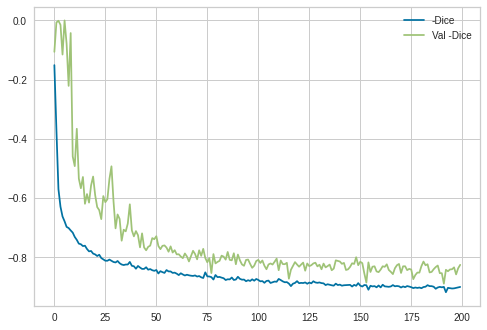

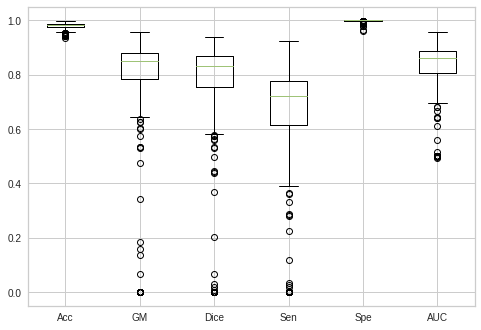

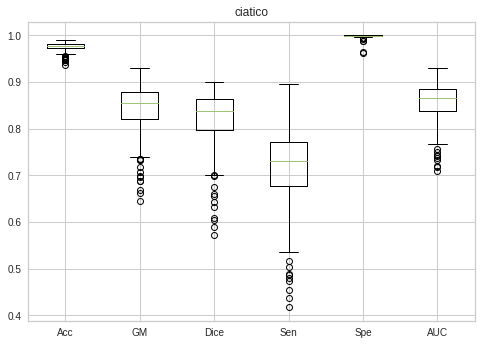

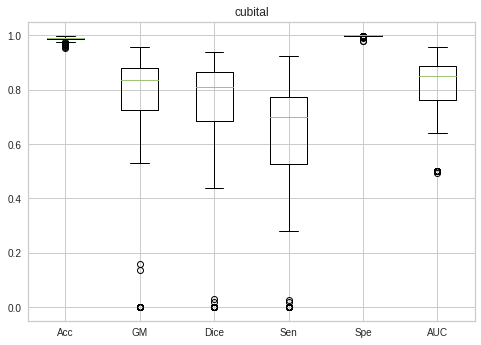

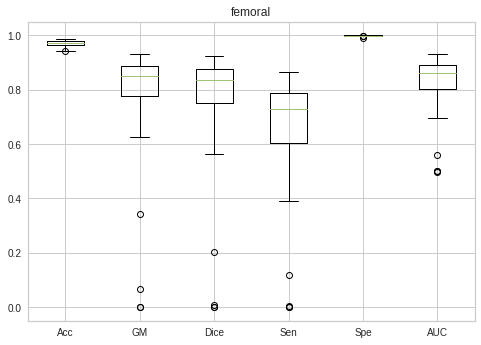

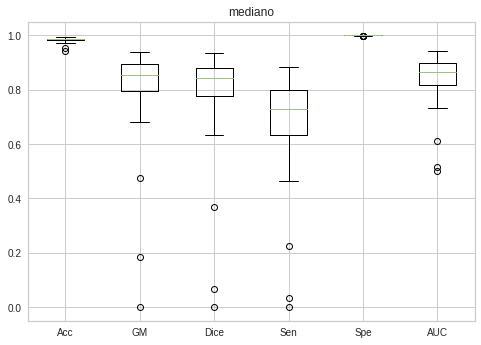

In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,roc_auc_score,confusion_matrix,recall_score
from joblib import dump
import pandas as pd
import os

EPOCHS = 200
BATCH_SIZE = batch_size

# a = 0.9
phi_units = 65
metrics = [iou, dice_coef, sensitivity, specificity, 'binary_accuracy']

excel_write = pd.ExcelWriter('results.xlsx')

for a in [1]:
  results_template = 'results_a-{}_phi-units-{}' # string template
  basepath = results_template.format(a,phi_units)
  try:
    os.mkdir(basepath)
  except:
    _ = 1

  tf.keras.backend.clear_session()

  seg_model = fcn((height,width))

  seg_model.compile(optimizer=Adam(lr=1e-3,clipnorm=5),
                    loss={'output':dice_coef_loss},
                    metrics = {'output':metrics})

  callbacks = [tf.keras.callbacks.ModelCheckpoint(basepath+'/Model_Checkpoint',
                                                  monitor='val_output_loss',
                                                  verbose=0,
                                                  mode = 'min')]

  history = seg_model.fit(train_gen,
                          steps_per_epoch=len(df_train_images) // BATCH_SIZE, 
                          epochs=EPOCHS , 
                          callbacks=callbacks,
                          validation_data = val_gen,
                          validation_steps=len(df_val_images) // BATCH_SIZE)

  # seg_model = tf.keras.Model(inputs = [seg_model.input],outputs=[seg_model.output[0]])


  plt.plot(history.history['loss'],label = '-Dice')
  plt.plot(history.history['val_loss'],label = 'Val -Dice')
  plt.legend()
  plt.savefig(basepath+'/LearningCurve.png')
  plt.show()


  seg_model.save(basepath+'/model.h5')
  ## Calculo de metricas de rendimiento. 


  filesname = df_test_images['filepath'].to_list()
  masks_files = df_test_images['mask'].to_list()
  test_t = df_test_images['nerve_name'].to_list()

  Acc = []
  Dice = []
  GM = []
  Sen = []
  Spe = []
  AUC = []
  CM = []
  for path_file,mask_file in zip(filesname,masks_files):
    image1 = np.array(Image.open(path_file).resize((height,width)))
    mask = np.array(Image.open(mask_file).resize((height,width))).reshape(-1,)
    mask_est = np.squeeze(seg_model.predict(np.expand_dims(image1,0)/255)[0,:,:,:].astype(np.uint8)).reshape(-1,)
    CM.append(confusion_matrix(mask,mask_est,labels=[0,1]))
    Acc.append(accuracy_score(mask,mask_est))
    sen = recall_score(mask,mask_est,pos_label=1,zero_division=0)
    spe = recall_score(mask,mask_est,pos_label=0,zero_division=0)
    Sen.append(sen)
    Spe.append(spe)
    GM.append(sqrt(sen*spe))
    Dice.append(f1_score(mask,mask_est,pos_label=1))
    AUC.append(roc_auc_score(mask,mask_est))

  mdict = {'Acc':Acc,
          'GM': GM,
          'Dice':Dice,
          'AUC':AUC,
          'Sen':Sen,
          'Spe':Spe,
          'nerve_name':test_t}

  pd.DataFrame(mdict).to_excel(excel_write,sheet_name='a-{}__phi-{}'.format(a,phi_units))

  plt.boxplot([Acc,GM,Dice,Sen,Spe,AUC])
  plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
  plt.savefig(basepath+'/Boxplot_all')
  plt.show()

  for name_nerve in ['ciatico','cubital','femoral','mediano']:
    Acc_aux = [Acc[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    Sen_aux = [Sen[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    Spe_aux = [Spe[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    Dice_aux = [Dice[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    GM_aux = [GM[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    AUC_aux = [AUC[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
    plt.boxplot([Acc_aux,GM_aux,Dice_aux,Sen_aux,Spe_aux,AUC_aux])
    plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','Sen','Spe','AUC'])
    plt.title(name_nerve)
    plt.savefig(basepath+'/Boxplot_{}'.format(name_nerve))
    plt.show()

  savedata = {'Acc':Acc,
              'GM':GM,
              'Dice':Dice,
              'Sen':Sen,
              'Spe':Spe,
              'AUC':AUC,
              'CM':CM,
              'train':df_train_images.to_dict(),
              'test':df_test_images.to_dict(),
              'val':df_val_images.to_dict()}
  dump(savedata,basepath+'/results.joblib')

excel_write.save()


In [ ]:
!zip -r results_FCN_v2 ./results*  model.png

  adding: results_a-1_phi-units-65/ (stored 0%)
  adding: results_a-1_phi-units-65/Boxplot_ciatico.png (deflated 16%)
  adding: results_a-1_phi-units-65/results.joblib (deflated 76%)
  adding: results_a-1_phi-units-65/LearningCurve.png (deflated 6%)
  adding: results_a-1_phi-units-65/Boxplot_femoral.png (deflated 19%)
  adding: results_a-1_phi-units-65/Boxplot_all.png (deflated 15%)
  adding: results_a-1_phi-units-65/Boxplot_cubital.png (deflated 18%)
  adding: results_a-1_phi-units-65/Model_Checkpoint/ (stored 0%)
  adding: results_a-1_phi-units-65/Model_Checkpoint/saved_model.pb (deflated 90%)
  adding: results_a-1_phi-units-65/Model_Checkpoint/assets/ (stored 0%)
  adding: results_a-1_phi-units-65/Model_Checkpoint/variables/ (stored 0%)
  adding: results_a-1_phi-units-65/Model_Checkpoint/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: results_a-1_phi-units-65/Model_Checkpoint/variables/variables.index (deflated 76%)
  adding: results_a-1_phi-units-65/Model_Checkpoint

In [ ]:
!cp results_FCN_v2.zip ./gdrive/MyDrive/